In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from dask.distributed import Client, LocalCluster
import dask
import logging

logging.basicConfig(level=logging.INFO)

client = Client(processes=False)

client

Client Scheduler: inproc://192.168.1.4/50963/1 Dashboard: http://localhost:8787/status,Cluster Workers: 1 Cores: 4 Memory: 17.18 GB


In [3]:
from src.load_data import load_data

epoch_key = ('bon', 3, 2)

data = load_data(epoch_key)

INFO:src.load_data:Finding ripple times...


In [17]:
from ipywidgets import interact

position_info = data['position_info']

@interact(time_ind=(0, position_info.shape[0]-1))
def _plot_1D_2D(time_ind=0):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].scatter(position_info.index.total_seconds().values, position_info.linear_position,
                    color='grey', alpha=0.7)
    axes[0].scatter(position_info.index.total_seconds().values[time_ind],
                    position_info.linear_position[time_ind], color='red', s=100)
    axes[1].plot(position_info.x_position, position_info.y_position, color='grey', alpha=0.7)
    axes[1].scatter(position_info.x_position[time_ind],
                    position_info.y_position[time_ind], color='red', s=100, zorder=10)

interactive(children=(IntSlider(value=0, description='time_ind', max=465497), Output()), _dom_classes=('widget…

In [18]:
from src.parameters import replay_speed, place_bin_size, movement_var, discrete_diag
from replay_trajectory_classification import SortedSpikesClassifier

position = position_info.linear_position
track_labels = position_info.arm_name
is_training = data['position_info'].speed > 4
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]

continuous_transition_types = (
    [['w_track_1D_random_walk', 'uniform', 'identity'],
     ['uniform',   'uniform', 'uniform'],
     ['w_track_1D_random_walk', 'uniform', 'identity']])

classifier = SortedSpikesClassifier(
    place_bin_size=1.0, movement_var=movement_var,
    replay_speed=10,
    discrete_transition_diag=discrete_diag,
    spike_model_penalty=0.5, knot_spacing=10,
    continuous_transition_types=continuous_transition_types).fit(
    position, data['spikes'], is_training=is_training, track_labels=track_labels)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


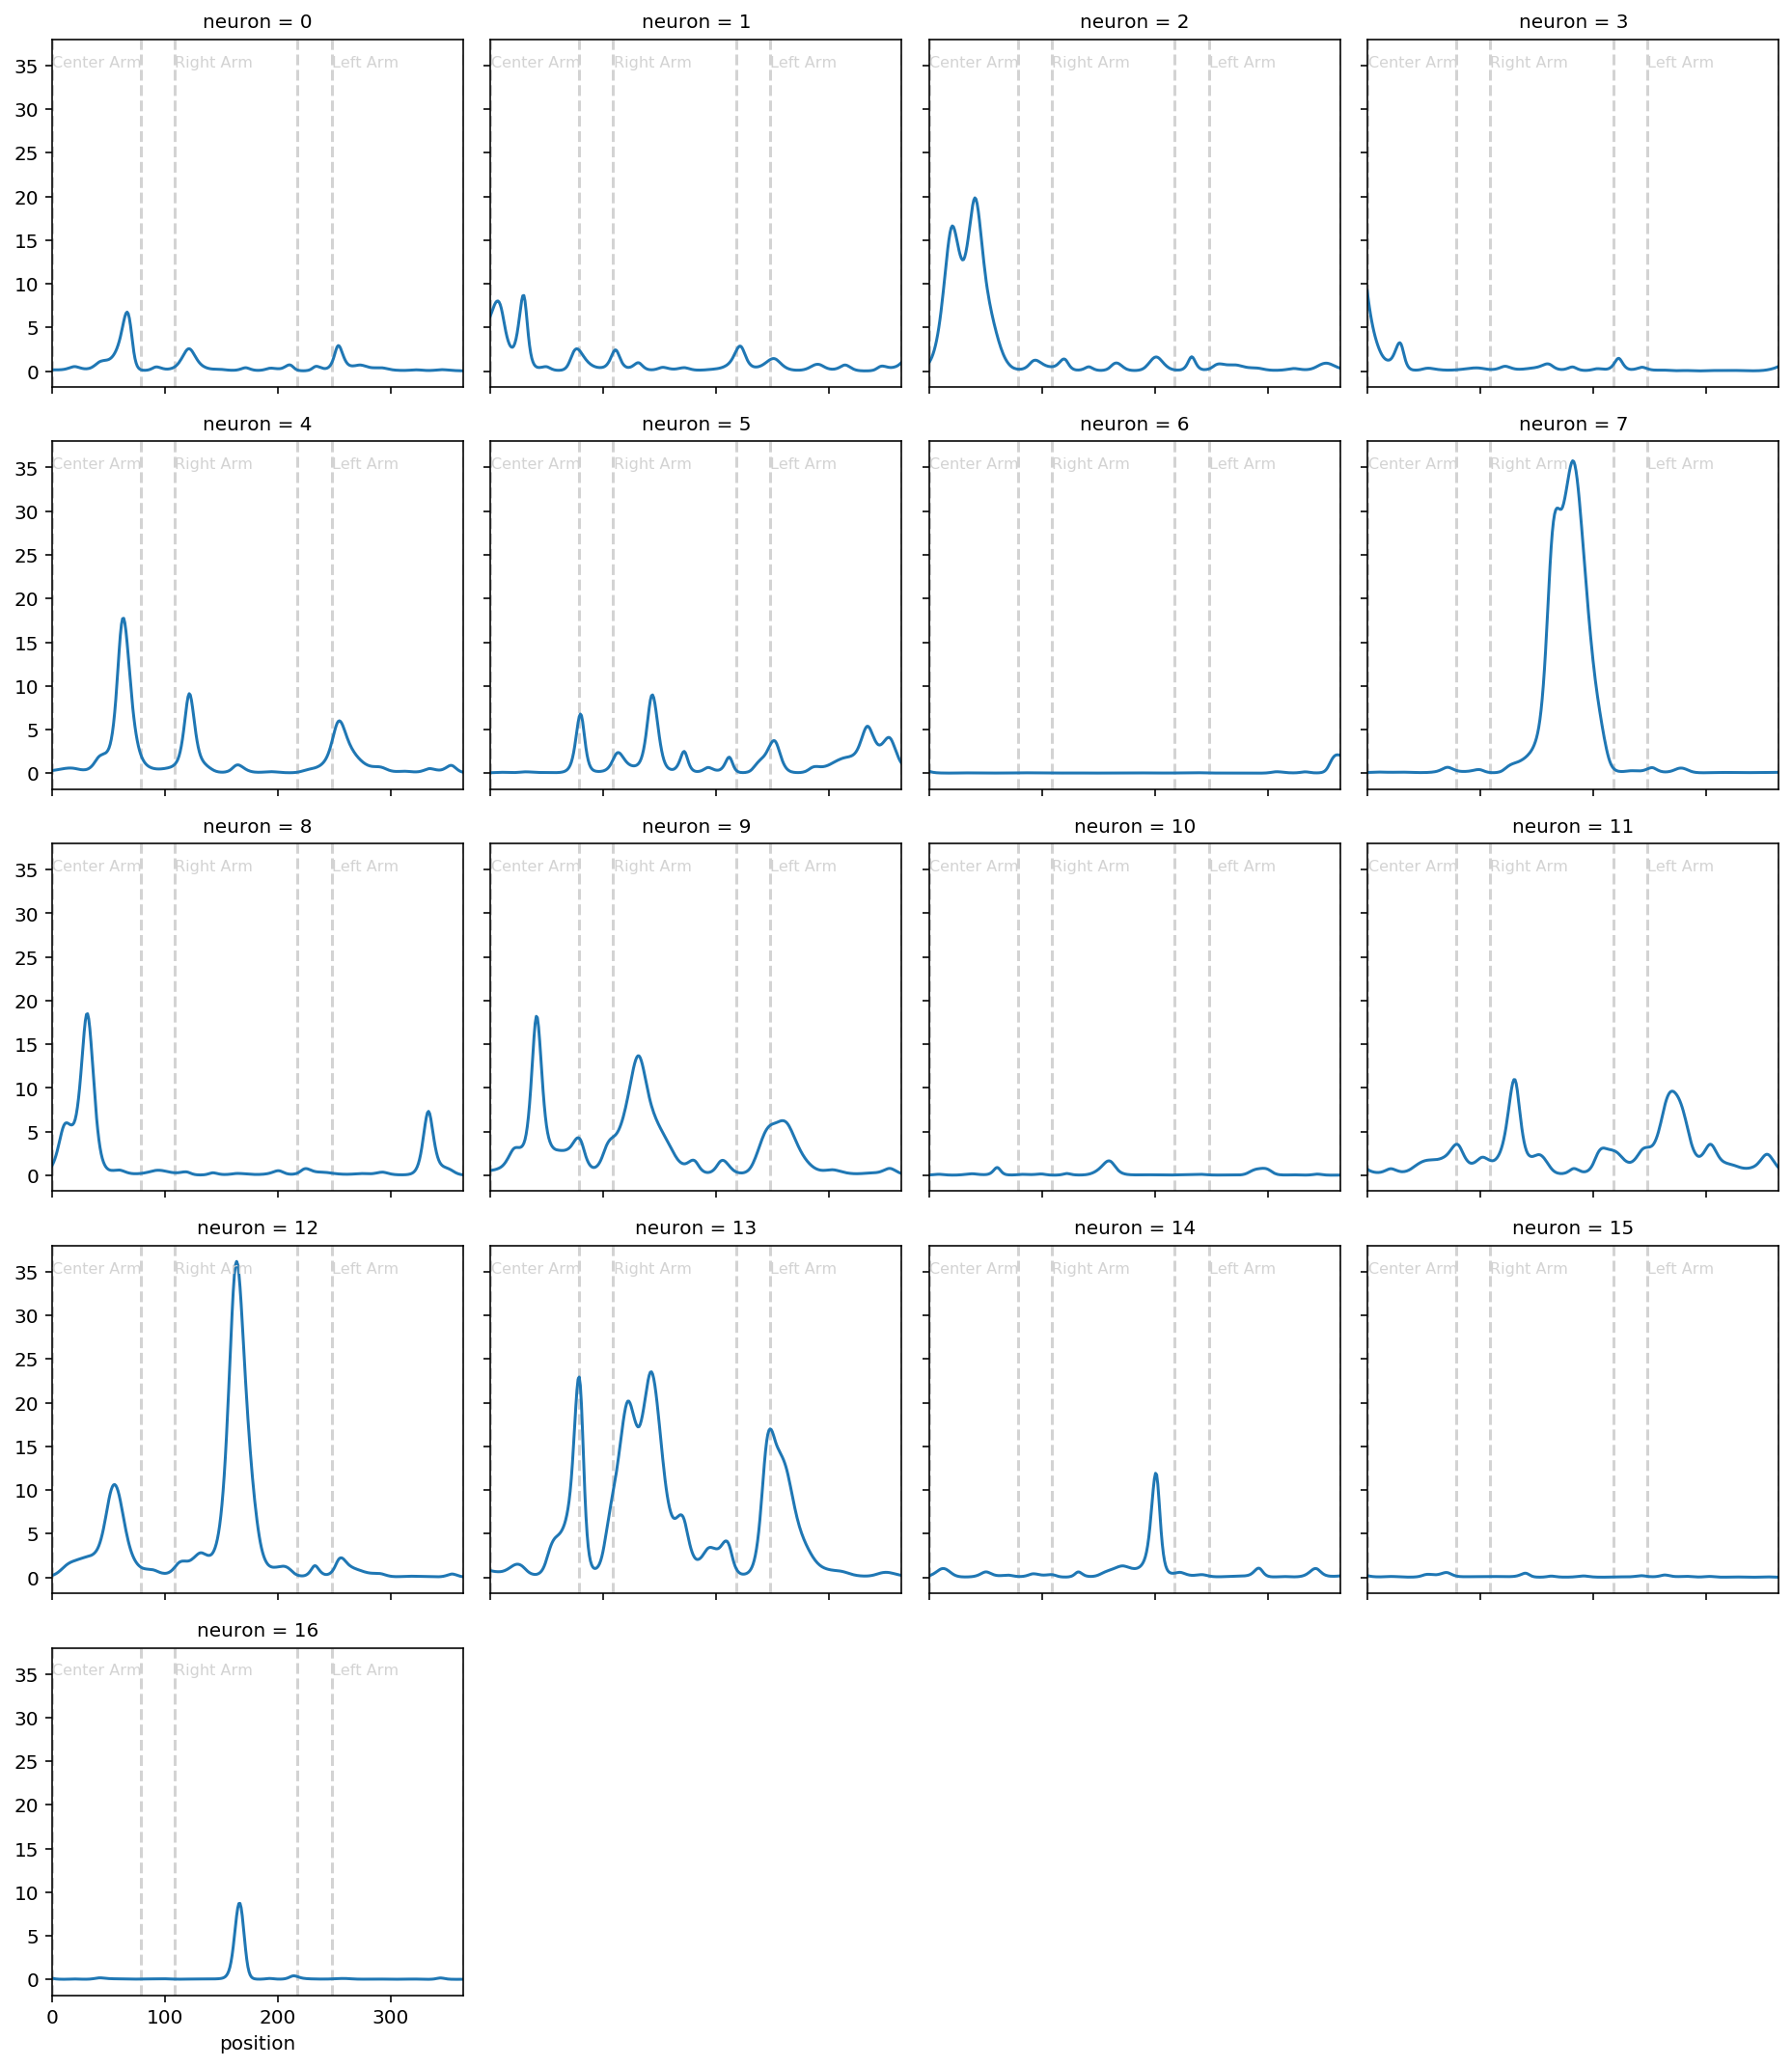

In [19]:
g = (classifier.place_fields_ * data['sampling_frequency']).plot(x='position', col='neuron', col_wrap=4)
max_df = position_info.groupby('arm_name').linear_position.max()
min_df = position_info.groupby('arm_name').linear_position.min()
plt.xlim((0, position_info.linear_position.max()))
max_rate = classifier.place_fields_.values.max() * data['sampling_frequency']
for ax in g.axes.flat:
    for arm_name, min_position in min_df.iteritems():
        ax.axvline(min_position, color='lightgrey', zorder=0,
                   linestyle='--')
        ax.text(min_position + 0.2, max_rate, arm_name, color='lightgrey',
                horizontalalignment='left', verticalalignment='top',
                fontsize=8)
    for arm_name, max_position in max_df.iteritems():
        ax.axvline(max_position, color='lightgrey', zorder=0,
                   linestyle='--')


In [21]:
from loren_frank_data_processing import reshape_to_segments

ripple_spikes = reshape_to_segments(
    data['spikes'], data['ripple_times'].loc[:, ['start_time', 'end_time']],
    sampling_frequency=data['sampling_frequency'])

ripple_position = reshape_to_segments(
    data['position_info'].loc[:, ['x_position', 'y_position', 'linear_position', 'track_segment_id']],
    data['ripple_times'].loc[:, ['start_time', 'end_time']],
    sampling_frequency=data['sampling_frequency'])

In [22]:
from src.analysis import get_linear_position_order, get_place_field_max
from src.parameters import TRANSITION_TO_CATEGORY, STATE_COLORS
from src.figure_utilities import set_figure_defaults, TWO_COLUMN, GOLDEN_RATIO
import seaborn as sns


set_figure_defaults()

def plot_classification(test_spikes, results, position_info):
    results = results.assign_coords(
        state=lambda ds: ds.state.to_index()
        .map(TRANSITION_TO_CATEGORY),
        time=lambda ds: 1000.0 * ds.time / np.timedelta64(1, 's')
    )
    place_field_max = get_place_field_max(classifier)
    linear_position_order = place_field_max.argsort(axis=0).squeeze()
    spike_time_ind, neuron_ind = np.nonzero(test_spikes[:, linear_position_order])
    replay_time = results.time.values
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 7), constrained_layout=True, sharex=True)
    
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=20, linewidth=1)
    axes[0].set_yticks((1, test_spikes.shape[1]))
    axes[0].set_xticks([])
    axes[0].set_xlim((replay_time.min(), replay_time.max()))
    axes[0].set_ylabel('Cells')
    
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        axes[1].plot(prob.time, prob.values, linewidth=2, label=state,
                color=STATE_COLORS[state])
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_xticks([])
    axes[1].set_xlim((replay_time.min(), replay_time.max()))
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].legend(bbox_to_anchor=(1.30, 0.95), loc='upper right', fancybox=False, shadow=False,
                   ncol=1, frameon=False)
    
    results.acausal_posterior.sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Pos. [cm]')
    axes[2].set_xlim((replay_time.min(), replay_time.max()))
    axes[2].set_xticks((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [ms]')
    
    max_df = position_info.groupby('arm_name').linear_position.max()
    min_df = position_info.groupby('arm_name').linear_position.min()
    axes[2].set_ylim((0, position_info.linear_position.max()))
    axes[2].set_yticks((0, position_info.linear_position.max()))
    
    max_df = (position_info
              .groupby('arm_name').linear_position.max())
    min_time = replay_time.min()
    for arm_name, max_position in max_df.iteritems():
        axes[2].axhline(max_position, color='grey',
                        linestyle='-', linewidth=1)
        axes[2].text(min_time, max_position - 5, arm_name, color='white',
                     fontsize=8, verticalalignment='top')
    min_df = (position_info
              .groupby('arm_name').linear_position.min())
    for arm_name, min_position in min_df.iteritems():
        axes[2].axhline(min_position, color='grey',
                        linestyle='-', linewidth=1)
    
    sns.despine()

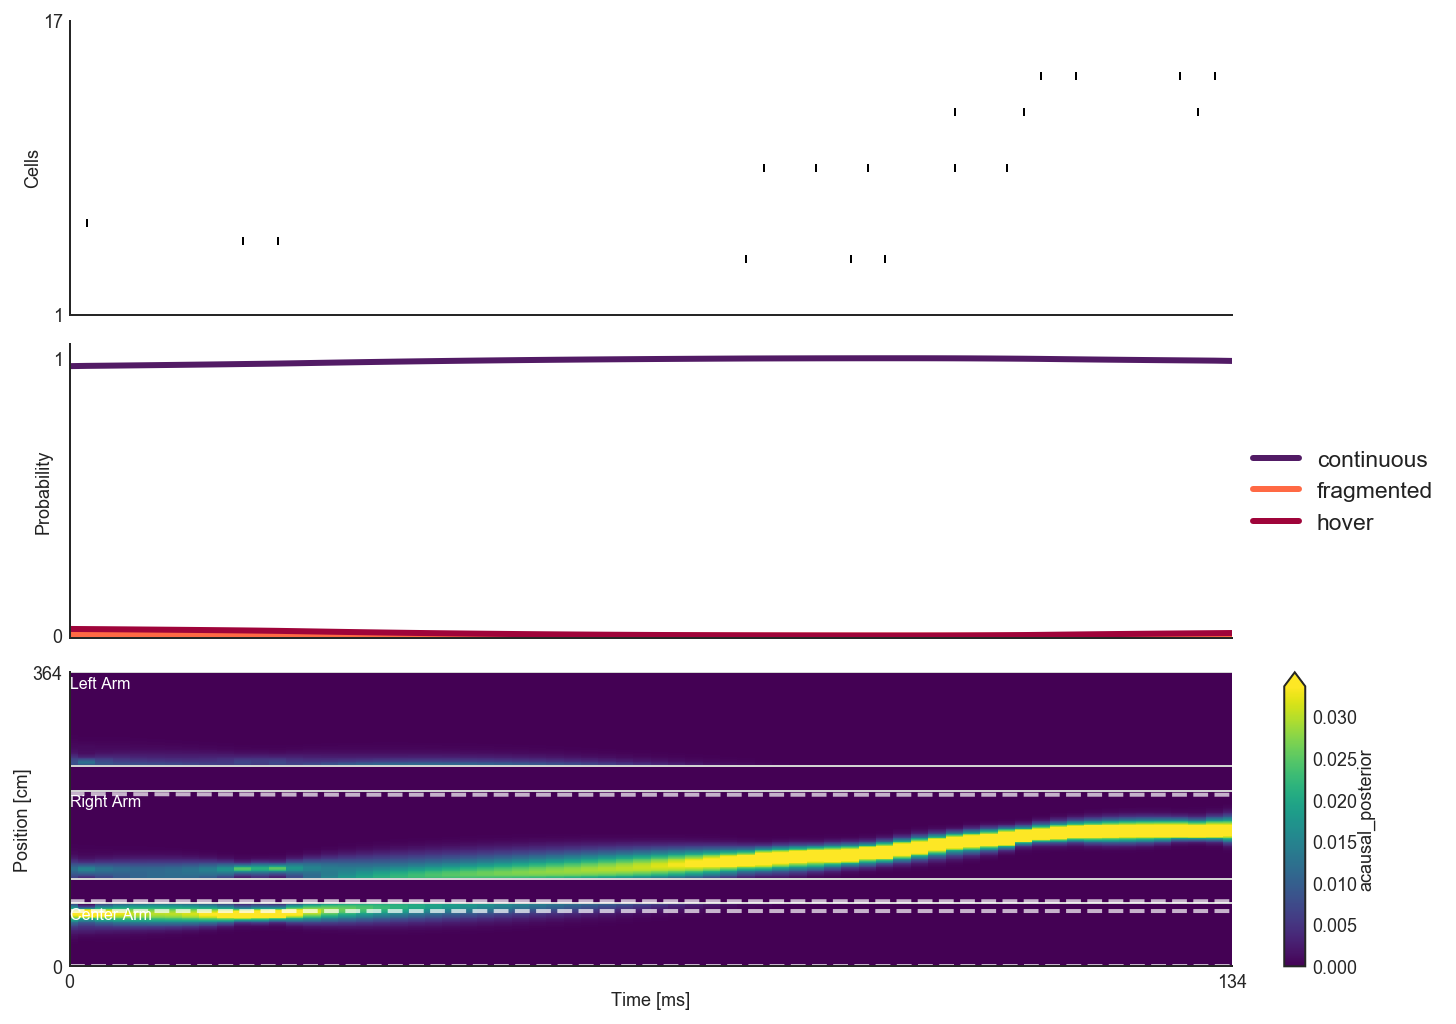

In [23]:
from src.visualization import plot_ripple_decode_1D

ripple_number = 153

result = classifier.predict(ripple_spikes.loc[ripple_number], time=ripple_spikes.loc[ripple_number].index)

place_field_max = get_place_field_max(classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()
posterior = (result
             .acausal_posterior
             .dropna('time')
             .assign_coords(
                 time=lambda ds: 1000.0 * ds.time / np.timedelta64(1, 's'),
                 state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)))

plot_ripple_decode_1D(posterior, ripple_position.loc[ripple_number], ripple_spikes.loc[ripple_number],
                      linear_position_order, data['position_info'],
                      spike_label='Cells')

NetworkXError: The edge 4-5 is not in the graph

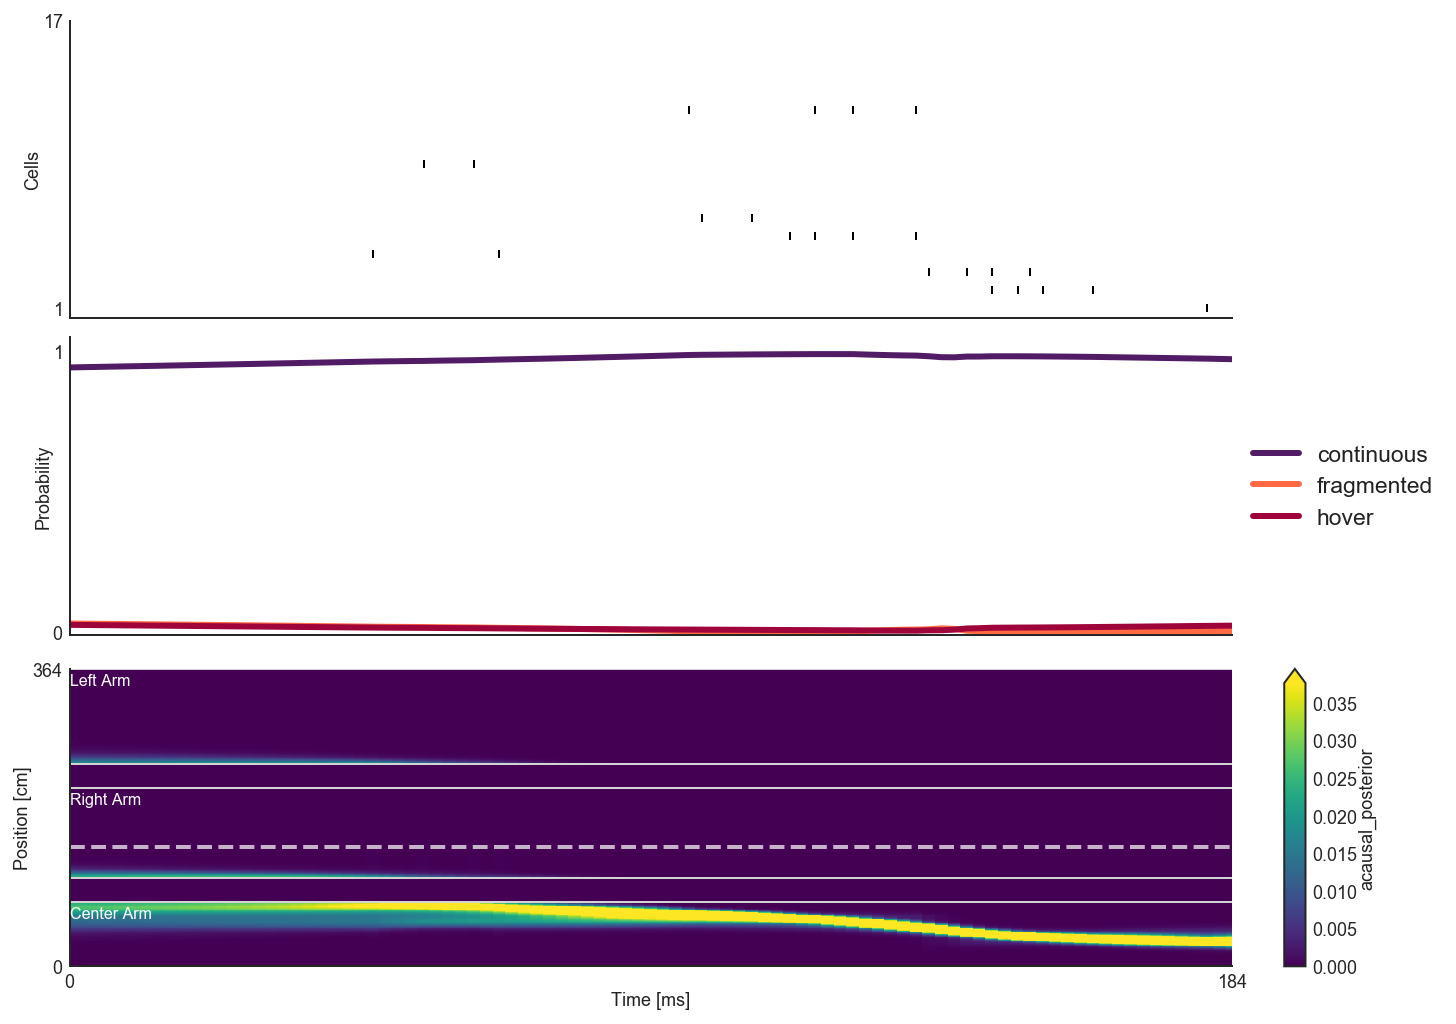

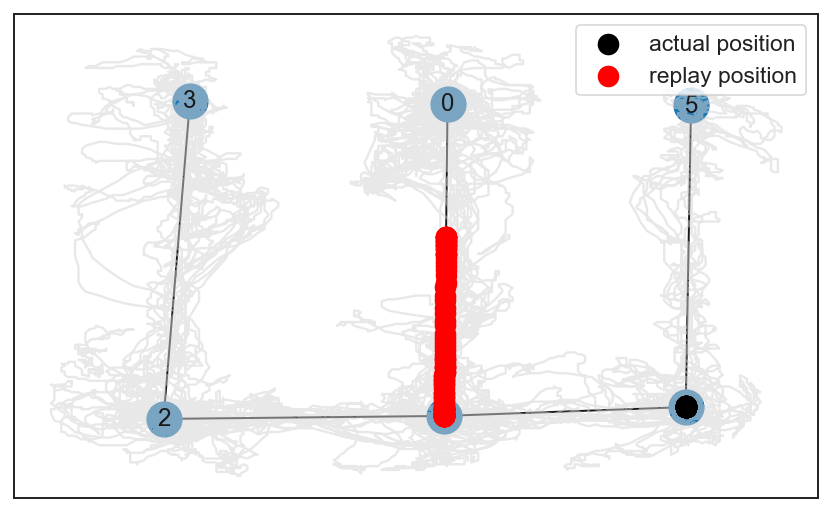

In [232]:
from src.analysis import maximum_a_posteriori_estimate
from loren_frank_data_processing.position import make_track_graph
from loren_frank_data_processing.track_segment_classification import project_points_to_segment, get_track_segments_from_graph, route_distances, plot_track
from src.parameters import ANIMALS

ripple_number = 175

track_graph, _ = make_track_graph(epoch_key, ANIMALS)
result = classifier.predict(ripple_spikes.loc[ripple_number], time=ripple_spikes.loc[ripple_number].index)

posterior = (result
             .acausal_posterior
             .dropna('time')
             .assign_coords(
                 time=lambda ds: 1000.0 * ds.time / np.timedelta64(1, 's'),
                 state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)))

place_field_max = get_place_field_max(classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()
posterior = (result
             .acausal_posterior
             .dropna('time')
             .assign_coords(
                 time=lambda ds: 1000.0 * ds.time / np.timedelta64(1, 's'),
                 state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)))

plot_ripple_decode_1D(posterior, ripple_position.loc[ripple_number], ripple_spikes.loc[ripple_number],
                      linear_position_order, data['position_info'],
                      spike_label='Cells')

track_graph, _ = make_track_graph(epoch_key, ANIMALS)


map_estimate = maximum_a_posteriori_estimate(posterior.sum('state'))

actual_position = ripple_position.loc[ripple_number, ['x_position', 'y_position']].values
actual_track_segment_ids = ripple_position.loc[ripple_number, 'track_segment_id'].values.squeeze().astype(int)


closest_ind = np.argmin(np.abs(map_estimate - data['position_info'].linear_position.values[np.newaxis, ...]), axis=1)
df = data['position_info'].iloc[closest_ind]
replay_position = df.loc[:, ['x_position', 'y_position']].values
replay_track_segment_ids = df.loc[:, ['track_segment_id']].values.squeeze().astype(int)
track_segments = get_track_segments_from_graph(track_graph)

def get_projected_track_positions(position, track_segments, track_segment_id):
    projected_track_positions = project_points_to_segment(
            track_segments, position)
    n_time = projected_track_positions.shape[0]
    projected_track_positions = projected_track_positions[(
        np.arange(n_time), track_segment_id)]
    return projected_track_positions

projected_replay_position = get_projected_track_positions(replay_position, track_segments, replay_track_segment_ids)
projected_actual_position = get_projected_track_positions(actual_position, track_segments, actual_track_segment_ids)


plt.figure()
plt.plot(data['position_info'].x_position, data['position_info'].y_position, alpha=0.5, color='lightgrey')
plt.scatter(projected_actual_position[:, 0], projected_actual_position[:, 1], zorder=10, color='black', s=100, label='actual position')
plt.scatter(projected_replay_position[:, 0], projected_replay_position[:, 1], zorder=10, color='red', s=100, label='replay position')
plt.legend()
plot_track(track_graph)


replay_edge_ids = np.asarray(track_graph.edges)[replay_track_segment_id]
actual_edge_ids = np.asarray(track_graph.edges)[actual_track_segment_id]
distance = []

zipped = zip(replay_edge_ids, actual_edge_ids, projected_actual_position, projected_replay_position,
             actual_track_segment_ids, replay_track_segment_ids)
for replay_edge_id, actual_edge_id, actual_pos, replay_pos, actual_id, replay_id in zipped:
    track_graph1 = track_graph.copy()
    if actual_id != replay_id:
        # Actual Position
        node1, node2 = actual_edge_id
        track_graph1.add_path([node1, 'actual_position', node2])
        track_graph1.remove_edge(node1, node2)
        track_graph1.nodes['actual_position']['pos'] = tuple(actual_pos)

        # Replay Position
        node1, node2 = replay_edge_id
        track_graph1.add_path([node1, 'replay_position', node2])
        track_graph1.remove_edge(node1, node2)
        track_graph1.nodes['replay_position']['pos'] = tuple(replay_pos)
    else:
        node1, node2 = actual_edge_id
        track_graph1.add_path(
            [node1, 'actual_position', 'replay_position', node2])
        track_graph1.add_path(
            [node1, 'replay_position', 'actual_position', node2])

        track_graph1.nodes['actual_position']['pos'] = tuple(actual_pos)
        track_graph1.nodes['replay_position']['pos'] = tuple(replay_pos)
        track_graph1.remove_edge(node1, node2)

    # calculate distance
    for edge in track_graph1.edges(data=True):
        track_graph1.edges[edge[:2]]['distance'] = np.linalg.norm(
            track_graph1.node[edge[0]]['pos'] -
            np.array(track_graph1.node[edge[1]]['pos']))

    distance.append(nx.shortest_path_length(track_graph1, source='actual_position',
                                        target='replay_position', weight='distance'))

plt.figure()
plt.plot(data['position_info'].x_position, data['position_info'].y_position, alpha=0.5, color='lightgrey')
plot_track(track_graph1)

plt.figure()
plt.plot(distance)

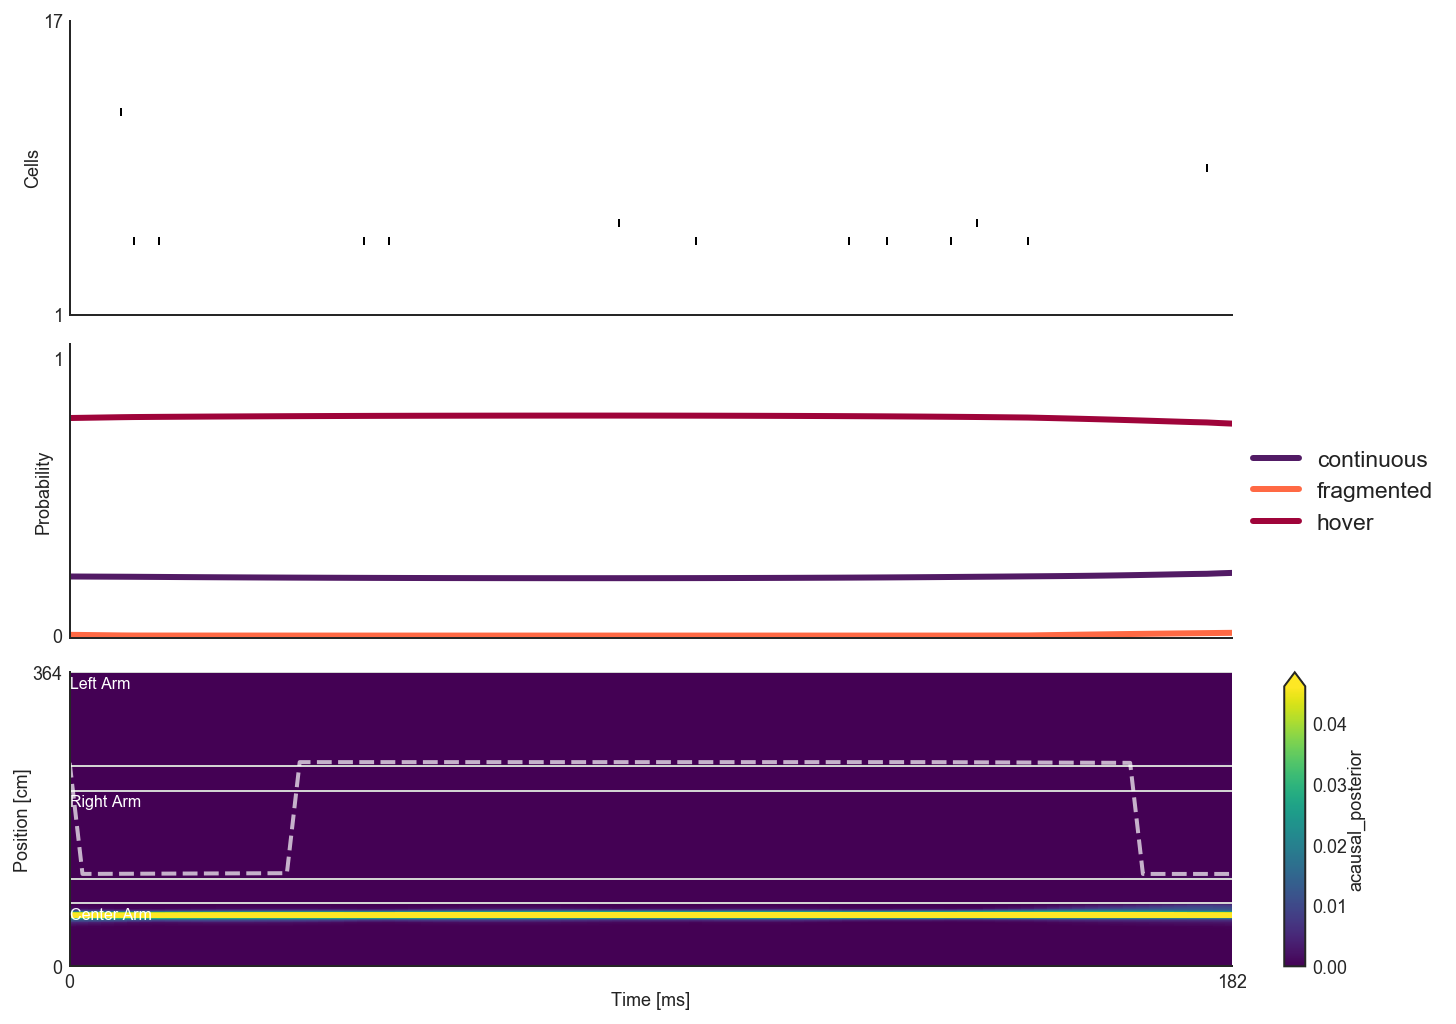

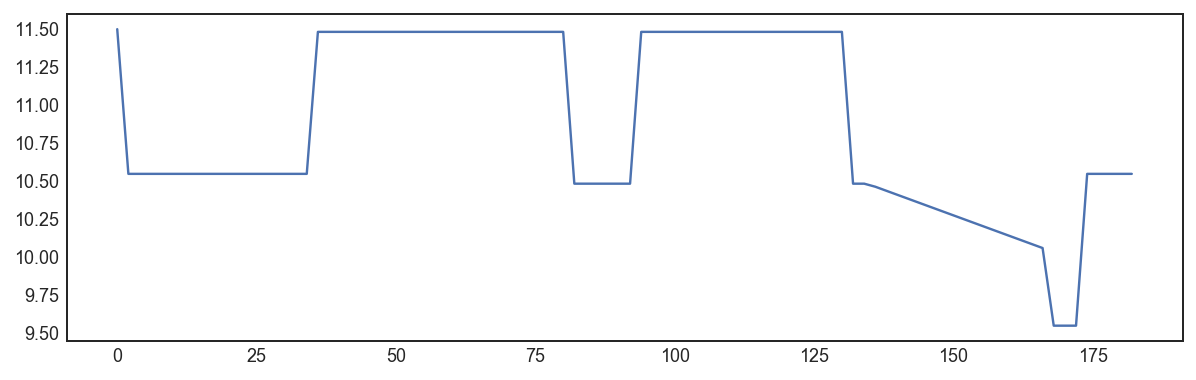

In [280]:
from src.analysis import calculate_replay_distance
ripple_number = 139

track_graph, _ = make_track_graph(epoch_key, ANIMALS)
result = classifier.predict(ripple_spikes.loc[ripple_number], time=ripple_spikes.loc[ripple_number].index)

posterior = (result
             .acausal_posterior
             .dropna('time')
             .assign_coords(
                 time=lambda ds: 1000.0 * ds.time / np.timedelta64(1, 's'),
                 state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)))

place_field_max = get_place_field_max(classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()
posterior = (result
             .acausal_posterior
             .dropna('time')
             .assign_coords(
                 time=lambda ds: 1000.0 * ds.time / np.timedelta64(1, 's'),
                 state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)))

plot_ripple_decode_1D(posterior, ripple_position.loc[ripple_number], ripple_spikes.loc[ripple_number],
                      linear_position_order, data['position_info'],
                      spike_label='Cells')

map_estimate = maximum_a_posteriori_estimate(posterior.sum('state'))

actual_positions = ripple_position.loc[ripple_number, ['x_position', 'y_position']].values
actual_track_segment_ids = ripple_position.loc[ripple_number, 'track_segment_id'].values.squeeze().astype(int)

distance = calculate_replay_distance(track_graph, map_estimate, actual_positions,
                                     actual_track_segment_ids, data['position_info'])
plt.figure(figsize=(10, 3))
plt.plot(posterior.time, distance)

In [24]:
from tqdm.auto import tqdm

from loren_frank_data_processing.position import make_track_graph
from src.analysis import (get_linear_position_order, get_place_field_max,
                          get_replay_info, reshape_to_segments)
from src.parameters import (ANIMALS, FIGURE_DIR, PROBABILITY_THRESHOLD,
                            PROCESSED_DATA_DIR, SAMPLING_FREQUENCY,
                            TRANSITION_TO_CATEGORY, discrete_diag, model,
                            model_kwargs, movement_var, place_bin_size,
                            replay_speed)

# Decode
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
ripple_spikes = reshape_to_segments(data['spikes'], ripple_times)
results = []
for ripple_number in tqdm(data['ripple_times'].index, desc='ripple'):
    ripple_time = (ripple_spikes.loc[ripple_number].index -
                   ripple_spikes.loc[ripple_number].index[0])
    results.append(
        classifier.predict(ripple_spikes.loc[ripple_number],
                           time=ripple_time))
results = (xr.concat(results, dim=data['ripple_times'].index)
           .assign_coords(state=lambda ds: ds.state.to_index()
                          .map(TRANSITION_TO_CATEGORY)))

In [25]:
from loren_frank_data_processing.position import make_track_graph
track_graph, _ = make_track_graph(epoch_key, ANIMALS)
replay_info = get_replay_info(
    results, ripple_spikes, data['ripple_times'], data['position_info'],
    track_graph, SAMPLING_FREQUENCY, PROBABILITY_THRESHOLD, epoch_key)

In [298]:
results

<xarray.Dataset>
Dimensions:            (position: 366, ripple_number: 252, state: 3, time: 127)
Coordinates:
  * time               (time) timedelta64[ns] 00:00:00 ... 00:00:00.252000
  * position           (position) float64 -0.4999 0.4999 1.5 ... 363.4 364.4
  * state              (state) object 'continuous' 'fragmented' 'hover'
  * ripple_number      (ripple_number) int64 1 2 3 4 5 6 ... 248 249 250 251 252
Data variables:
    likelihood         (ripple_number, time, state, position) float64 0.0 ... nan
    causal_posterior   (ripple_number, time, state, position) float64 0.0 ... nan
    acausal_posterior  (ripple_number, time, state, position) float64 0.0 ... nan

In [464]:
from ipywidgets import interact
from IPython.display import display

classified_index = replay_info.loc[replay_info.is_classified].index

@interact(ind=(0, len(classified_index)-1))
def plot_ripple(ind=0):
    ripple_number = classified_index[ind]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    (results
     .sel(ripple_number=ripple_number)
     .dropna('time')
     .assign_coords(time=lambda ds: 1000 * ds.time / np.timedelta64(1, 's'))
     .acausal_posterior
     .sum('state').plot(x='time', y='position', robust=True, ax=axes[0]))
    max_df = (position_info
          .groupby('arm_name').linear_position.max())
    for arm_name, max_position in max_df.iteritems():
        axes[0].axhline(max_position, color='lightgrey',
                        linestyle='-', linewidth=1)
        axes[0].text(0, max_position - 5, arm_name, color='white',
                     fontsize=8, verticalalignment='top')
    min_df = (position_info
              .groupby('arm_name').linear_position.min())
    for arm_name, min_position in min_df.iteritems():
        axes[0].axhline(min_position, color='lightgrey',
                        linestyle='-', linewidth=1)
    ripple_time = ripple_position.loc[ripple_number].index.total_seconds().values * 1000
    axes[0].plot(ripple_time, ripple_position.loc[ripple_number].linear_position.values,
                    color='white', linestyle='--', linewidth=2, alpha=0.7)
    (results
     .sel(ripple_number=ripple_number)
     .dropna('time')
     .assign_coords(time=lambda ds: 1000 * ds.time / np.timedelta64(1, 's'))
     .acausal_posterior
     .sum('position').plot(x='time', hue='state', ax=axes[1]))
    axes[1].set_ylim((0, 1))
    display(ripple_position.loc[ripple_number].linear_position.mean())
    display(replay_info
            .loc[ripple_number]
            .filter(regex='fragmented.*|continuous.*|hover.*', axis=0)
            .dropna())

interactive(children=(IntSlider(value=0, description='ind', max=161), Output()), _dom_classes=('widget-interac…

In [74]:
from src.analysis import maximum_a_posteriori_estimate, reshape_to_segments

ripple_number = 153

ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]
position_info = data['position_info']

ripple_position_info = reshape_to_segments(position_info, ripple_times)

posterior = (results
                 .sel(ripple_number=ripple_number)
                 .acausal_posterior
                 .dropna('time')
                 .assign_coords(
                     time=lambda ds: 1000 * ds.time / np.timedelta64(1, 's')))
map_estimate = maximum_a_posteriori_estimate(posterior.sum('state'))

actual_positions = (ripple_position_info
                    .loc[ripple_number, ['x_position', 'y_position']]
                    .values)
actual_track_segment_ids = (ripple_position_info
                            .loc[ripple_number, 'track_segment_id']
                            .values.squeeze().astype(int))

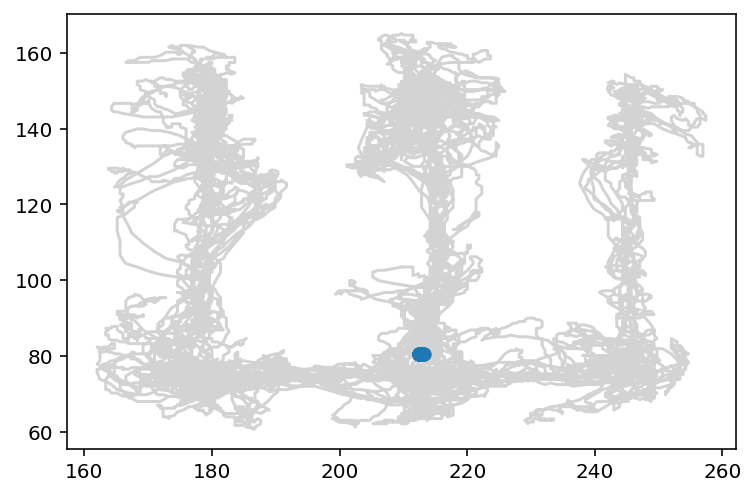

In [75]:
plt.plot(position_info.x_position, position_info.y_position, color='lightgrey')
plt.scatter(actual_positions[:, 0], actual_positions[:, 1], zorder=10)

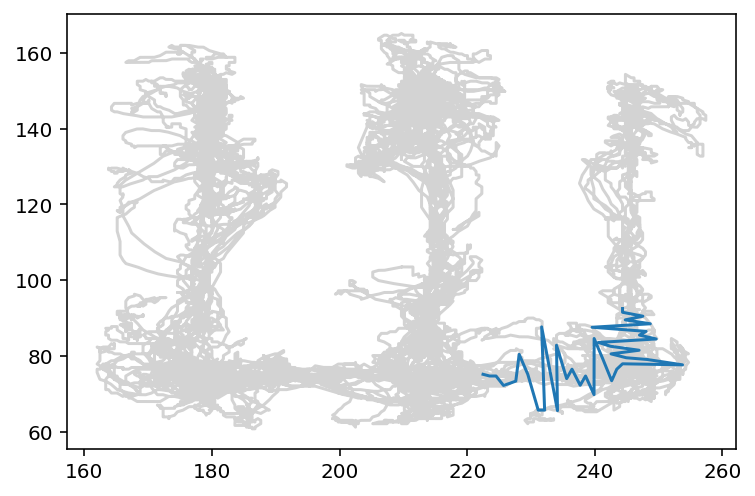

In [85]:
from src.analysis import _get_closest_ind

actual_track_segment_ids = (
    np.asarray(actual_track_segment_ids).squeeze().astype(int))
closest_ind = _get_closest_ind(
            map_estimate, position_info.linear_position)
df = position_info.iloc[closest_ind]
plt.plot(position_info.x_position, position_info.y_position, color='lightgrey')
plt.plot(df.x_position, df.y_position, zorder=10)

In [86]:
replay_positions = df.loc[:, ['x_position', 'y_position']].values
replay_track_segment_ids = (
    df.loc[:, ['track_segment_id']].values.squeeze().astype(int))
replay_track_segment_ids

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4])

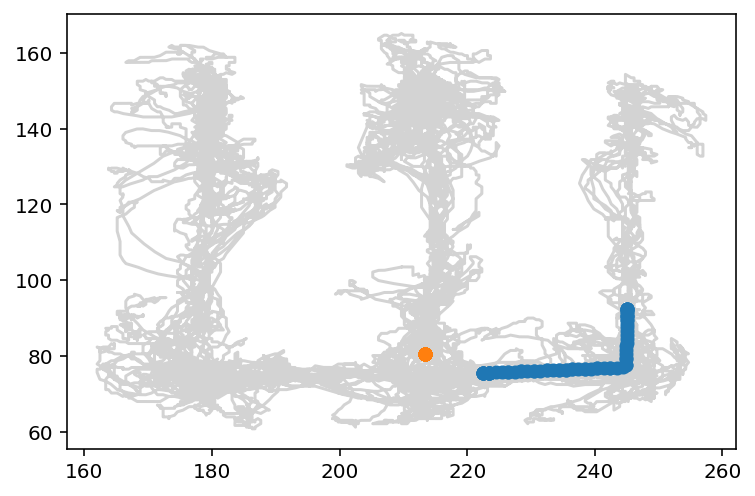

In [96]:
from src.analysis import get_track_segments_from_graph, _get_projected_track_positions

track_segments = get_track_segments_from_graph(track_graph)
# Project positions to closest edge on graph
replay_positions = _get_projected_track_positions(
    replay_positions, track_segments, replay_track_segment_ids)
actual_positions = _get_projected_track_positions(
    actual_positions, track_segments, actual_track_segment_ids)

plt.plot(position_info.x_position, position_info.y_position, color='lightgrey')
plt.scatter(replay_positions[:, 0], replay_positions[:, 1], zorder=10)
plt.scatter(actual_positions[:, 0], actual_positions[:, 1], zorder=10)

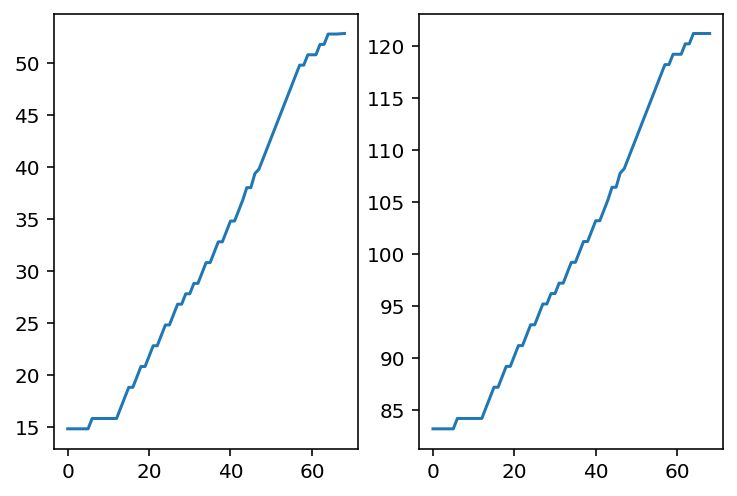

In [106]:
import networkx as nx

center_well_id = 0

edges = np.asarray(track_graph.edges)
replay_edge_ids = edges[replay_track_segment_ids]
actual_edge_ids = edges[actual_track_segment_ids]
replay_distance_from_actual_position = []
replay_distance_from_center_well = []

zipped = zip(
    actual_edge_ids, replay_edge_ids, actual_positions, replay_positions,
    actual_track_segment_ids, replay_track_segment_ids)

for (actual_edge_id, replay_edge_id, actual_pos, replay_pos,
     actual_id, replay_id) in zipped:
    track_graph1 = track_graph.copy()
    if actual_id != replay_id:
        # Add actual position node
        node_name = 'actual_position'
        node1, node2 = actual_edge_id
        track_graph1.add_path([node1, node_name, node2])
        track_graph1.remove_edge(node1, node2)
        track_graph1.nodes[node_name]['pos'] = tuple(actual_pos)

        # Add replay position node
        node_name = 'replay_position'
        node1, node2 = replay_edge_id
        track_graph1.add_path([node1, node_name, node2])
        track_graph1.remove_edge(node1, node2)
        track_graph1.nodes[node_name]['pos'] = tuple(replay_pos)
    else:
        node1, node2 = actual_edge_id

        track_graph1.add_path(
            [node1, 'actual_position', 'replay_position', node2])
        track_graph1.add_path(
            [node1, 'replay_position', 'actual_position', node2])

        track_graph1.nodes['actual_position']['pos'] = tuple(actual_pos)
        track_graph1.nodes['replay_position']['pos'] = tuple(replay_pos)
        track_graph1.remove_edge(node1, node2)
        
    # Calculate distance between all nodes
    for edge in track_graph1.edges(data=True):
        track_graph1.edges[edge[:2]]['distance'] = np.linalg.norm(
            track_graph1.node[edge[0]]['pos'] -
            np.array(track_graph1.node[edge[1]]['pos']))

    replay_distance_from_actual_position.append(
        nx.shortest_path_length(
            track_graph1, source='actual_position',
            target='replay_position', weight='distance'))
    replay_distance_from_center_well.append(
        nx.shortest_path_length(
            track_graph1, source=center_well_id,
            target='replay_position', weight='distance'))

replay_distance_from_actual_position = np.asarray(
    replay_distance_from_actual_position)
replay_distance_from_center_well = np.asarray(
    replay_distance_from_center_well)

fig, axes = plt.subplots(1, 2)
axes[0].plot(replay_distance_from_actual_position)
axes[1].plot(replay_distance_from_center_well)

In [109]:
# linear position
SEGMENT_ID_TO_ARM_NAME = {0.0: 'Center Arm',
                          1.0: 'Left Arm',
                          2.0: 'Right Arm',
                          3.0: 'Left Arm',
                          4.0: 'Right Arm'}
arm_names = [SEGMENT_ID_TO_ARM_NAME[segment_id]
             for segment_id in replay_track_segment_ids]
np.asarray(arm_names)

array(['Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm',
       'Right Arm', 'Right Arm', 'Right Arm', 'Right Arm'], dtyp

In [110]:
replay_position_df = pd.DataFrame(
    {'linear_distance': replay_distance_from_center_well,
     'arm_name': arm_names})
replay_position_df

,linear_distance,arm_name
0,83.178329,Right Arm
1,83.178329,Right Arm
2,83.178329,Right Arm
3,83.178329,Right Arm
4,83.178329,Right Arm
5,83.178329,Right Arm
6,84.175444,Right Arm
7,84.175444,Right Arm
8,84.175444,Right Arm
9,84.175444,Right Arm


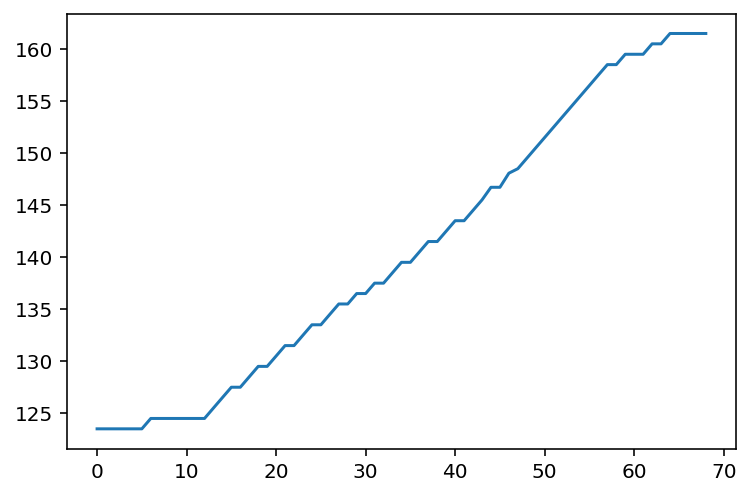

In [116]:
from src.analysis import _calulcate_linear_position2


replay_linear_position = np.asarray(_calulcate_linear_position2(
    pd.concat((replay_position_df, position_info.loc[:, ['linear_distance', 'arm_name']]), axis=0), spacing=30))
replay_linear_position = replay_linear_position[:len(replay_position_df)]
plt.plot(replay_linear_position)

[(0, 1), (1, 2), (1, 4), (2, 3), (4, 5)]


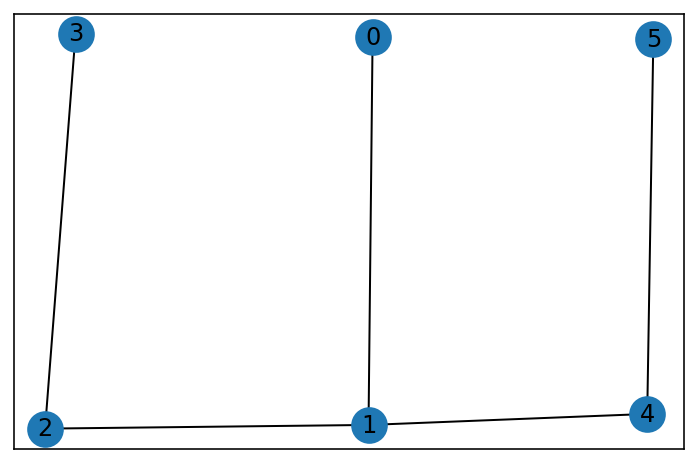

In [69]:
from loren_frank_data_processing.position import make_track_graph
from loren_frank_data_processing.track_segment_classification import plot_track

track_graph, _ = make_track_graph(epoch_key, ANIMALS)
plot_track(track_graph)
print(track_graph.edges)

<xarray.DataArray 'acausal_posterior' (time: 54)>
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])
Coordinates:
  * time           (time) float64 0.0 2.0 4.0 6.0 ... 100.0 102.0 104.0 106.0
    ripple_number  int64 1
    state          <U10 'fragmented'

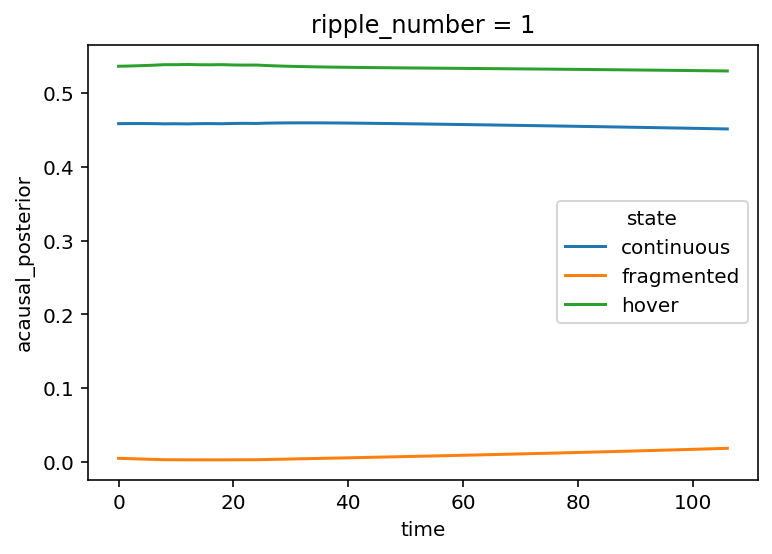

In [150]:
ripple_number = 1
posterior = (results
                 .sel(ripple_number=ripple_number)
                 .acausal_posterior
                 .dropna('time')
                 .assign_coords(
                     time=lambda ds: 1000 * ds.time / np.timedelta64(1, 's')))

probabilities = posterior.sum('position')
probabilities.plot(x='time', hue='state')

((probabilities.sel(state='hover') + probabilities.sel(state='continuous') > 0.8) &
 (probabilities.sel(state='fragmented') <= 0.2))

In [266]:
probability = results.acausal_posterior.sum('position', skipna=False)

probability = xr.concat(
    (probability,
     probability
        .sel(state=['hover', 'continuous'])
        .sum('state', skipna=False)
        .assign_coords(state='hover-continuous-mix'),
     probability
        .sel(state=['fragmented', 'continuous'])
        .sum('state', skipna=False)
        .assign_coords(state='fragmented-continuous-mix'),
     ), dim='state')

is_classified = probability > 0.8

is_classified.loc[dict(state='hover-continuous-mix')] = (
    is_classified.sel(state='hover-continuous-mix') &
    ~is_classified.sel(state='hover') &
    ~is_classified.sel(state='continuous'))

is_classified.loc[dict(state='fragmented-continuous-mix')] = (
    is_classified.sel(state='fragmented-continuous-mix') &
    ~is_classified.sel(state='fragmented') &
    ~is_classified.sel(state='continuous'))
is_classified = is_classified.rename('is_classified')
is_classified = is_classified.where(~np.isnan(probability))

In [267]:
sampling_frequency = data['sampling_frequency']
duration = (is_classified.sum('time') / sampling_frequency)
duration = duration.to_dataframe().unstack(level=1)
duration.columns = duration.columns.droplevel(None).rename('')
duration = duration.rename(
    columns=lambda column_name: column_name + '_duration')
is_category = (duration > 0.0).rename(columns=lambda c: c.split('_')[0])
duration = pd.concat((duration, is_category), axis=1)
duration['is_classified'] = np.any(duration > 0.0, axis=1)
duration

,continuous_duration,fragmented_duration,fragmented-continuous-mix_duration,hover_duration,hover-continuous-mix_duration,continuous,fragmented,fragmented-continuous-mix,hover,hover-continuous-mix,is_classified
ripple_number,,,,,,,,,,,
1,0.000,0.00,0.000,0.0,0.108,False,False,False,False,True,True
2,0.000,0.00,0.000,0.0,0.120,False,False,False,False,True,True
3,0.000,0.00,0.000,0.0,0.108,False,False,False,False,True,True
4,0.000,0.00,0.000,0.0,0.056,False,False,False,False,True,True
5,0.000,0.00,0.000,0.0,0.058,False,False,False,False,True,True
6,0.000,0.00,0.000,0.0,0.082,False,False,False,False,True,True
7,0.000,0.00,0.000,0.0,0.060,False,False,False,False,True,True
8,0.000,0.00,0.000,0.0,0.080,False,False,False,False,True,True
9,0.000,0.00,0.000,0.0,0.062,False,False,False,False,True,True


In [265]:
posterior = (results
             .sel(ripple_number=ripple_number)
             .acausal_posterior
             .dropna('time')
             .assign_coords(
                 time=lambda ds: 1000 * ds.time / np.timedelta64(1, 's')))

is_classified.sel(ripple_number=ripple_number).dropna('time')

<xarray.DataArray 'is_classified' (time: 54, state: 5)>
array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])
Coordinates:
  * time           (time) timedelta64[ns] 00:00:00 ... 00:00:00.106000
    ripple_number  int64 1
  * state          (state) object 'continuous' ... 'fragmented-continuous-mix'

In [290]:
d = data['position_info'].iloc[data['position_info'].index.searchsorted(data['ripple_times'].loc[1].start_time)]
data['position_info'].groupby('labeled_segments').task.apply(lambda df: df[0]).loc[d.labeled_segments - 1]

KeyError: -1.0

In [324]:
from src.analysis import calculate_replay_distance

ripple_number = 1

posterior = (results
             .sel(ripple_number=ripple_number)
             .acausal_posterior
             .dropna('time')
             .assign_coords(
                 time=lambda ds: 1000 * ds.time / np.timedelta64(1, 's')))

map_estimate = maximum_a_posteriori_estimate(posterior.sum('state'))
actual_positions = (ripple_position_info
                    .loc[ripple_number, ['x_position', 'y_position']]
                    .values)
actual_track_segment_ids = (ripple_position_info
                            .loc[ripple_number, 'track_segment_id']
                            .values.squeeze().astype(int))

(replay_distance_from_actual_position, replay_distance_from_center_well,
 replay_linear_position) = calculate_replay_distance(
    track_graph, map_estimate, actual_positions,
    actual_track_segment_ids, position_info)

for state, above_threshold in is_classified.sel(ripple_number=ripple_number).dropna('time').groupby('state'):
    above_threshold = above_threshold.astype(bool).squeeze()
    state_distance = replay_distance_from_actual_position[above_threshold]


4.498934498608839

In [327]:
replay_info.loc[1]['hover-continuous-mix_replay_distance_from_center_well']

4.498934498608839

# Clusterless

In [359]:
from src.parameters import replay_speed, place_bin_size, movement_var, discrete_diag, model, model_kwargs
from replay_trajectory_classification import ClusterlessClassifier

position = position_info.linear_position
track_labels = position_info.arm_name
is_training = data['position_info'].speed > 4
ripple_times = data['ripple_times'].loc[:, ['start_time', 'end_time']]

continuous_transition_types = (
    [['w_track_1D_random_walk', 'uniform', 'identity'],
     ['uniform',   'uniform', 'uniform'],
     ['w_track_1D_random_walk', 'uniform', 'identity']])

classifier = ClusterlessClassifier(
    place_bin_size=1.0, movement_var=movement_var,
    replay_speed=replay_speed,
    discrete_transition_diag=discrete_diag,
    continuous_transition_types=continuous_transition_types,
    model=model, model_kwargs=model_kwargs).fit(
    position, data['multiunit'], is_training=is_training, track_labels=track_labels)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting multiunits...


KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [58]:
ripple_number = 100
time_slice = slice(*data['ripple_times'].loc[
    ripple_number, ['start_time', 'end_time']])
m = data['multiunit'].sel(time=time_slice)
result = classifier.predict(m, m.time - m.time[0])


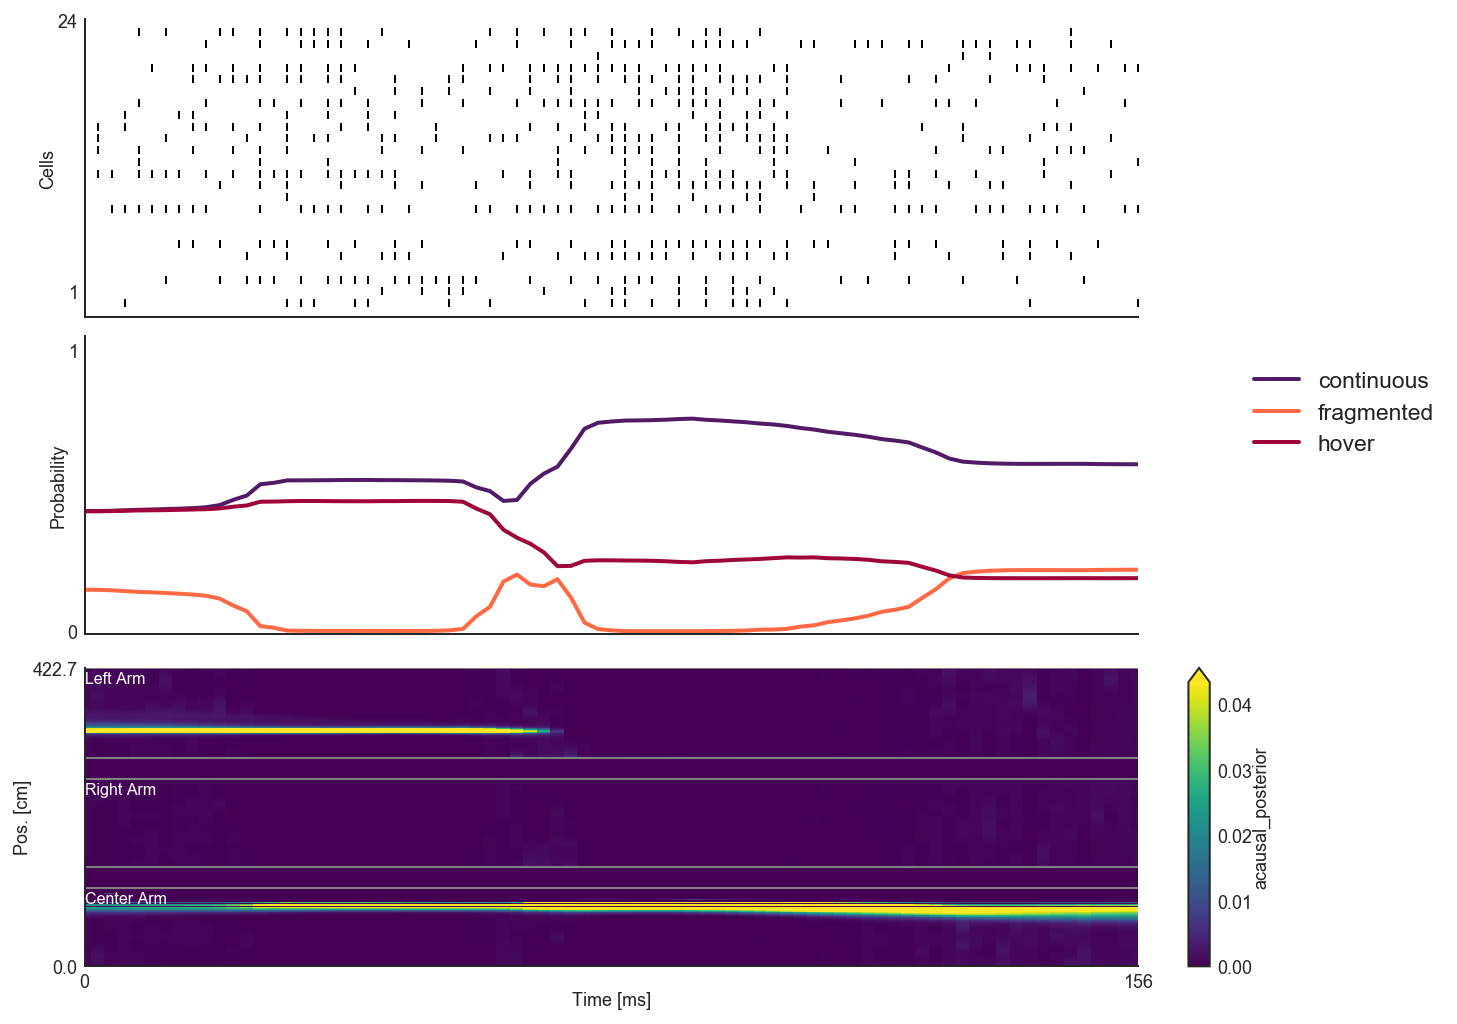

In [59]:
from loren_frank_data_processing import reshape_to_segments

spikes = (((data['multiunit'].sum('features') > 0) * 1.0)
          .to_dataframe(name='spikes').unstack())
spikes.columns = data['tetrode_info'].tetrode_id
ripple_spikes = reshape_to_segments(spikes, ripple_times)
plot_classification(ripple_spikes.loc[ripple_number].values, result, data['position_info'])